<a href="https://colab.research.google.com/github/LaughBuddha/Audio-Source-Separation/blob/master/NMF_implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# **Non-negative matrix factorization**

Non-negative matrix factorization (NMF) is one of the classical methods used to decompose the magnitude of time-frequency distributions in audio processing. 

The fundamental process of NMF is factorizing the matrix V containing the audio data spectrogram into two separate matrices referred to as bases (W ) and activations (H ) respectively. All three matrices V, W, H are non-negative.

$\mathrm{V}_{m \times n} = W_{m \times r}H_{r \times n}$

$r = min(m, n)$ is the number of source components

NP-hard problem and no close form solution

KL divergence cost function optimized 
$D_{KL}(\mathrm{V} \parallel U) = \sum\left(V \odot  \log \frac{V}{U} - V + U \right)$

where $\mathrm{U} \approx WH$

W and H are estimated by the following equantions

$W \leftarrow W \odot \frac{\frac{V}{U}\times \mathrm{H}^T}{J \times \mathrm{H}^{T}}$

$H \leftarrow H \odot \frac{\mathrm{W}^{T} \times \frac{V}{U} }{\mathrm{W}^{T} \times J}$


The notebook is structured as follows.

1. Load the musdb18 dataset and converts the files to wav format
2. Compute the STFT of the audio data.
3. Apply NMFD with audio-informed initialization of the components
4. Visualize the decomposition results.
5. Resynthesizes the separated audio streams and saves them as wav files to the hard drive.
6. Calculate results  - Energy ratios - SDR, SIR, and SAR

Python package NMF toolbox used to implement NMF which is described in the below work.

Reference:

[1] Christian Dittmar, Meinard Müller
Reverse Engineering the Amen Break - Score-informed Separation and
Restoration applied to Drum Recordings
IEEE/ACM Transactions on Audio, Speech, and Language Processing,
24(9): 1531-1543, 2016.

# **Mount google drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
import os
os.chdir('/content/drive/My Drive/522_Music_Separation_Task/NMFtoolbox/python')

# **Install NMF toolbox**

In [ ]:
!python setup.py develop

running develop
running egg_info
writing NMFtoolbox.egg-info/PKG-INFO
writing dependency_links to NMFtoolbox.egg-info/dependency_links.txt
writing requirements to NMFtoolbox.egg-info/requires.txt
writing top-level names to NMFtoolbox.egg-info/top_level.txt
reading manifest file 'NMFtoolbox.egg-info/SOURCES.txt'
writing manifest file 'NMFtoolbox.egg-info/SOURCES.txt'
running build_ext
Creating /usr/local/lib/python3.6/dist-packages/NMFtoolbox.egg-link (link to .)
Adding NMFtoolbox 0.0.0 to easy-install.pth file

Installed /content/drive/My Drive/522_Music_Separation_Task/NMFtoolbox/python
Processing dependencies for NMFtoolbox==0.0.0
Searching for matplotlib==3.1.1
Reading https://pypi.org/simple/matplotlib/
Best match: matplotlib 3.1.1
Processing matplotlib-3.1.1-cp36-cp36m-manylinux1_x86_64.whl
Installing matplotlib-3.1.1-cp36-cp36m-manylinux1_x86_64.whl to /usr/local/lib/python3.6/dist-packages
Adding matplotlib 3.1.1 to easy-install.pth file

Installed /usr/local/lib/python3.6/dist-

# **Install MUSDB**

In [ ]:
!pip install musdb

     |████████████████████████████████| 512kB 5.8MB/s 


# **Install MIR_EVAL**

In [ ]:
!pip install mir_eval

     |████████████████████████████████| 92kB 2.4MB/s 
  Created wheel for mir-eval: filename=mir_eval-0.6-cp36-none-any.whl size=96515 sha256=994d199708755ac27c7564661fcb3fa1c12e5fba108255a2fcc2c60b46f04213
  Stored in directory: /root/.cache/pip/wheels/49/ce/30/730fa72addf275e49d90683b01b3613048b4be3bf7ff8eb6ec
Successfully built mir-eval


# **Convert MUSDB mp4 files to WAV format**

In [ ]:
!musdbconvert --download /root/MUSDB18 /root/MUSDB18_wav

Done!
100% 144/144 [02:54<00:00,  1.21s/it]


# **Import Libraries**

In [ ]:
import os
import numpy as np
import scipy.io.wavfile as wav
import IPython.display as ipd

from NMFtoolbox.forwardSTFT import forwardSTFT
from NMFtoolbox.inverseSTFT import inverseSTFT
from NMFtoolbox.initTemplates import initTemplates
from NMFtoolbox.initActivations import initActivations
from NMFtoolbox.NMFD import NMFD
from NMFtoolbox.alphaWienerFilter import alphaWienerFilter
from NMFtoolbox.visualizeComponentsNMF import visualizeComponentsNMF
from NMFtoolbox.utils import make_monaural, pcmInt16ToFloat32Numpy

from IPython.display import Audio, display
import musdb
import mir_eval

# **1. Load Dataset**

In [ ]:
mus_wav = musdb.DB(root="/root/MUSDB18_wav", subsets='test', is_wav = True)

track_wav = mus_wav[1]
print(track_wav.name)
display(Audio(track_wav.audio.T, rate=track_wav.rate))

Al James - Schoolboy Facination


In [ ]:
x = make_monaural(track_wav.audio)
x = pcmInt16ToFloat32Numpy(x)

# **2. compute STFT**

In [ ]:
# spectral parameters
paramSTFT = dict()
paramSTFT['blockSize'] = 4096
paramSTFT['hopSize'] = 1024
paramSTFT['winFunc'] = np.hanning(paramSTFT['blockSize'])
paramSTFT['reconstMirror'] = True
paramSTFT['appendFrame'] = True
paramSTFT['numSamples'] = len(x)

# STFT computation
X, A, P = forwardSTFT(x, paramSTFT)

# get dimensions and time and freq resolutions
numBins, numFrames = X.shape
deltaT = paramSTFT['hopSize'] / track_wav.rate
deltaF = track_wav.rate / paramSTFT['blockSize']

# **3. Apply NMF variants to STFT magnitude**

In [ ]:
# set common parameters
numComp = 4
numIter = 30
numTemplateFrames = 8

# generate initial guess for templates
paramTemplates = dict()
paramTemplates['deltaF'] = deltaF
paramTemplates['numComp'] = numComp
paramTemplates['numBins'] = numBins
paramTemplates['numTemplateFrames'] = numTemplateFrames

initW = initTemplates(paramTemplates,'random')

# generate initial activations
paramActivations = dict()
paramActivations['numComp'] = numComp
paramActivations['numFrames'] = numFrames

initH = initActivations(paramActivations,'uniform')

# NMFD parameters
paramNMFD = dict()
paramNMFD['numComp'] = numComp
paramNMFD['numFrames'] = numFrames
paramNMFD['numIter'] = numIter
paramNMFD['numTemplateFrames'] = numTemplateFrames
paramNMFD['initW'] = initW
paramNMFD['initH'] = initH

# NMFD core method
nmfdW, nmfdH, nmfdV, divKL, _ = NMFD(A, paramNMFD)

# alpha-Wiener filtering
nmfdA, _ = alphaWienerFilter(A, nmfdV, 1.0)

# **4. Visualize spectrographs**

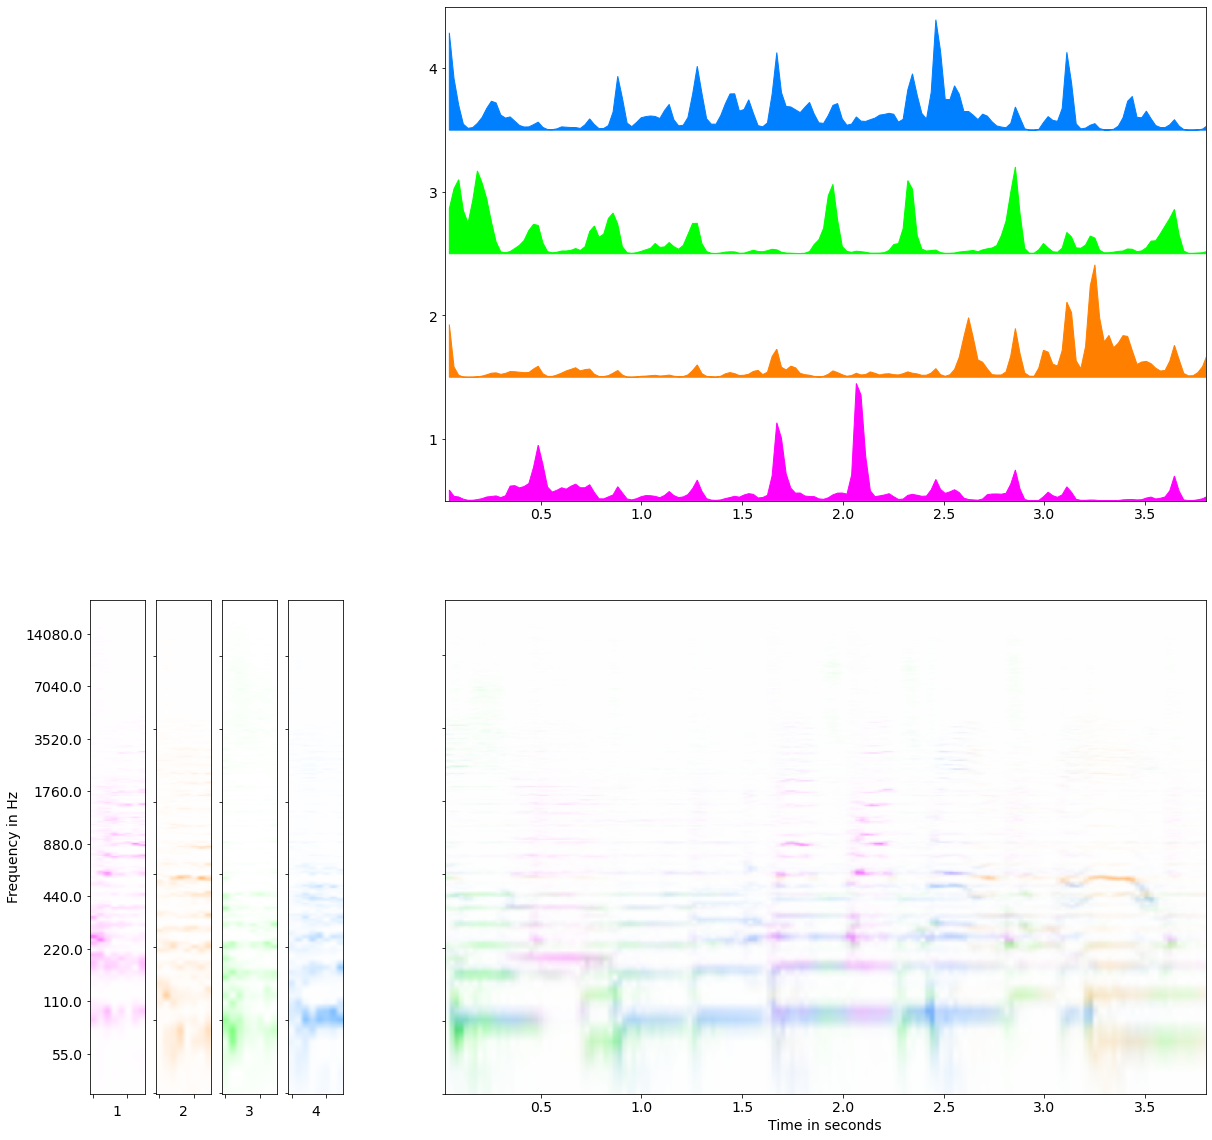

In [ ]:
#visualize
paramVis = dict()
paramVis['deltaT'] = deltaT
paramVis['deltaF'] = deltaF
paramVis['endeSec'] = 3.8

# paramVis['endeSec'] = 0.001
paramVis['fontSize'] = 14
fh1, _ = visualizeComponentsNMF(A, nmfdW, nmfdH, nmfdA, paramVis)

In [ ]:
audios = []

# resynthesize results of NMF with soft constraints and score information
for k in range(numComp):
    Y = nmfdA[k] * np.exp(1j * P);
    y, _ = inverseSTFT(Y, paramSTFT)
    
    audios.append(y)
    # save result
    
    out_filepath = '/content/nmf_source_separated_output.wav'
    
    wav.write(filename=out_filepath, rate=track_wav.rate, data=y)

## **Mixture track/signal**

In [ ]:
display(Audio(x, rate=track_wav.rate))

#### 1st source signal

In [ ]:
display(Audio(audios[0].T, rate=track_wav.rate))

#### 2nd source signal

In [ ]:
display(Audio(audios[1].T, rate=track_wav.rate))

#### 3rd source signal

In [ ]:
display(Audio(audios[2].T, rate=track_wav.rate))

### 4th source signal

In [ ]:
display(Audio(audios[3].T, rate=track_wav.rate))

# **Calculate evaluation metrics - SDR, SIR, SAR**

In [ ]:
a  = make_monaural(track_wav.stems[0])
b  = make_monaural(track_wav.stems[1])
c  = make_monaural(track_wav.stems[2])
d  = make_monaural(track_wav.stems[3])

reference = np.array([a,b,c,d])
audios = np.array(audios)
reference = reference.reshape(4,300032)
audios = audios.reshape(4, 300032)

In [ ]:
sdr, sir, sar, perm = mir_eval.separation.bss_eval_sources(reference, audios)

# As per the **perm** output the best ordering of estimated sources is as follows.

audios[0] - vocals

audios[2] - drums

audios[1] - bass

audios[3] - others


In [ ]:
print(perm)

[0 2 1 3]


In [ ]:
for i in perm:
  print("SDR: {}, SIR: {}, SAR: {}".format(sdr[i], sir[i], sar[i]))

SDR: -8.019685437129846, SIR: -5.498025826636494, SAR: 2.1180790438461243
SDR: -1.745630944735285, SIR: 0.7243017828580638, SAR: 4.545185930900509
SDR: -10.929655243147124, SIR: -9.012042170264625, SAR: 3.0698286499443506
SDR: 2.7244527863642447, SIR: 12.885062072440942, SAR: 3.3824827144327223


In [ ]:
print('Overall SDR: ', sdr.mean())
print('Overall SIR: ', sir.mean())
print('Overall SAR: ', sar.mean())

Overall SDR:  -1.9925658301663725
Overall SIR:  1.5541774102187669
Overall SAR:  4.006036325989828
